In [1]:
import qubecalib as qc
import qubecalib.ui as ui
from qubecalib import UpConverter, LocalOscillator
from qubecalib.ui import Qube
import e7awgsw

QUBE = Qube()
display(ui.LoadConfigPanel(QUBE))
# ハードウェアのコンフィグが終わっていれば，Load した時点で Qube オブジェクトから QuBE を操れる

LoadConfigPanel(children=(Text(value='qube_riken_1-01.yml', description='Config'), Button(description='Load', …

In [2]:
print(QUBE.qube.ad9082[0].get_jesd_status())
print(QUBE.qube.ad9082[1].get_jesd_status())
print(QUBE.config['iplsi'])
print(QUBE.config['ipfpga'])
print(QUBE.config['bitfile'])

AttributeError: 'NoneType' object has no attribute 'ad9082'

In [10]:
def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.local.lsi, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.local.lsi)

def set_nco(port, mhz):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)


def sendrecv(wave_params, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*AWG_LIST)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, wave_params)
        # キャプチャパラメータの設定
        sr.set_capture_params(
            cap_ctrl,
            awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
            awg_to_wave_sequence[AWG_LIST.readout_awg_0],
            capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*AWG_LIST)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
    return capture_unit_to_capture_data

def myplot(axs, data):
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in data.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    for i, v in enumerate(o[::4]):
        axs[i,0].plot(time, v[:,0])
        axs[i,1].plot(time, v[:,1])

# パルスシーケンスのテスト

## send_recv_dsp/send_recv_integ.py

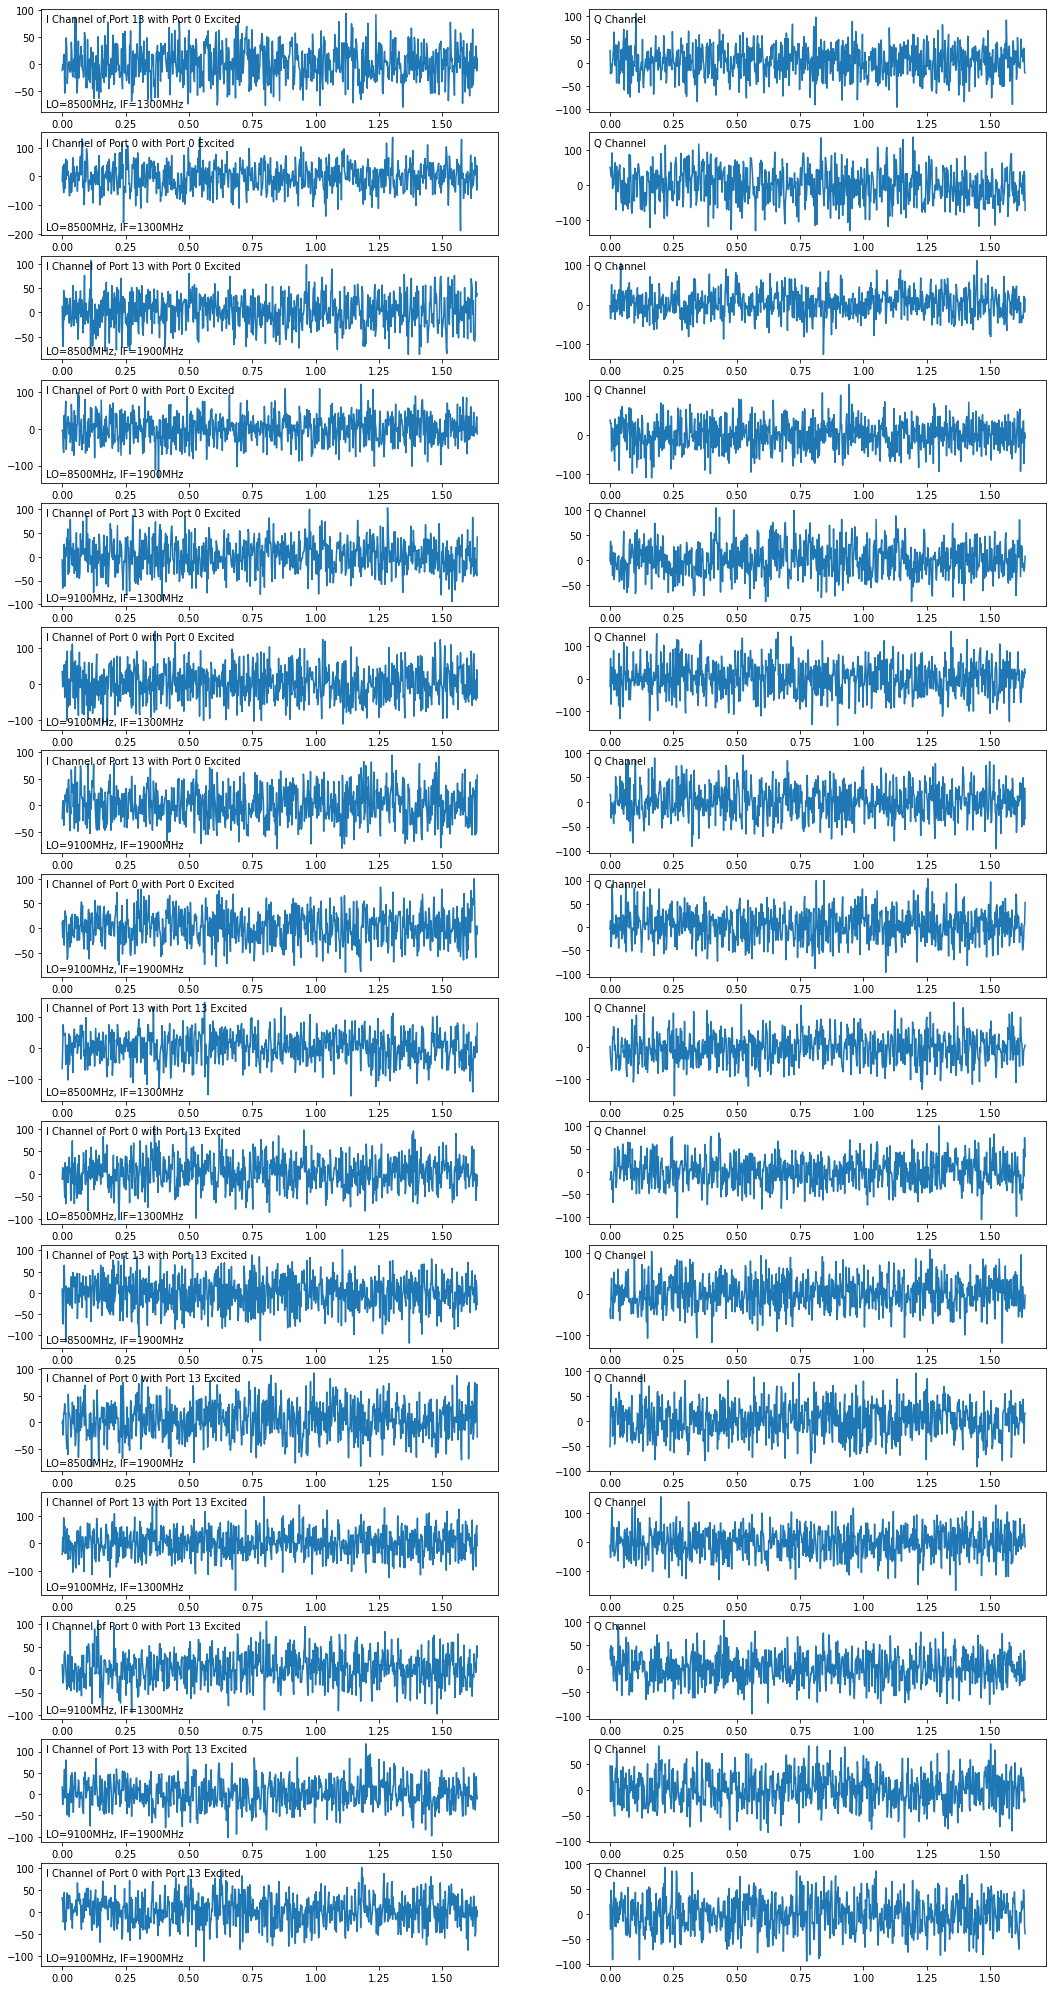

In [11]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
from collections import namedtuple
import pickle

def set_vatt(vatt, v, apply=True): # max 4095
    vatt.dac.write_value(vatt.ch, v)
    if apply:
        apply_vatt(vatt.dac)


qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'
wparams = sr.wave_params(
    num_wait_words = 0,
    ctrl_freq = 100, # MHz
    ctrl_wave_len = ctrl_wave_len, # ns
    readout_freq = 100, # MHz,
    readout_wave_len = 500, # ns,
    readout_blank_len = 0.1, # ms
    # num_chunk_repeats = 10000, # 積算回数
    num_chunk_repeats = 1, # 積算回数
)

set_sideband_config(qube.adrf6780, qube_type='A')

# # 9800, 10400, 11000
#FL, FI = 8500, 1300
#FL, FI = 8500, 1900
#FL, FI = 9100, 1300
#FL, FI = 9100, 1900

VATT = 0xC00
Rx = namedtuple('Rx', ('fl', 'fi', 'port', 'data'))
rslt = []
# PORT_ID = 13 # 0 or 13
# FL, FI = 8500, 1300
family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
# try:
for PORT_ID in [0, 13]:
    for FL, FI in ((8500, 1300), (8500, 1900), (9100, 1300), (9100, 1900)):
        set_lo_nco(port[PORT_ID], FL, FI - 2.5)
        [set_nco_ifadc(port[PORT_ID], FI - 2.5, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
        qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)
        #set_lo_nco(port[PORT_ID], FL, FI - 2.5)
        # port[PORT_ID].set_lo(FL)
        # port[PORT_ID].set_if(FI - 2.5)
        # [port[PORT_ID].dac.lsi.set_nco(freq=(FI-2.5)*1e+6, ch=i, adc_mode=True) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
        qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)
        rslt.append(Rx(fl = FL, fi = FI, port = PORT_ID, data = sendrecv(wparams, capture_modules, False, server_ip_addr)))
        d = sendrecv(wparams, capture_modules, False, server_ip_addr)
# finally:
#     with open(fname, 'wb') as f:
#         pickle.dump(rslt, f)
        
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

f, axs = plt.subplots(16,2, figsize=(18,36))
for i, d in enumerate(rslt):
    ax = axs[2*i:,:]
    myplot(ax, d.data)
    for k in [0, 1]:
        ax[k,0].text(0.01, 0.05, 'LO={}MHz, IF={}MHz'.format(d.fl, d.fi), transform=ax[k,0].transAxes)
        ax[k,0].text(0.01, 0.95, 'I Channel of Port {} with Port {} Excited'.format(['13', '0'][k], d.port), verticalalignment='top', transform=ax[k,0].transAxes)
        ax[k,1].text(0.01, 0.95, 'Q Channel', verticalalignment='top', transform=ax[k,1].transAxes)# o = [np.array(v) for k, v in d.items()]
# time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
# for i, v in enumerate(o[::4]):
#     axs[i,0].plot(time, v[:,0])
#     axs[i,1].plot(time, v[:,1])

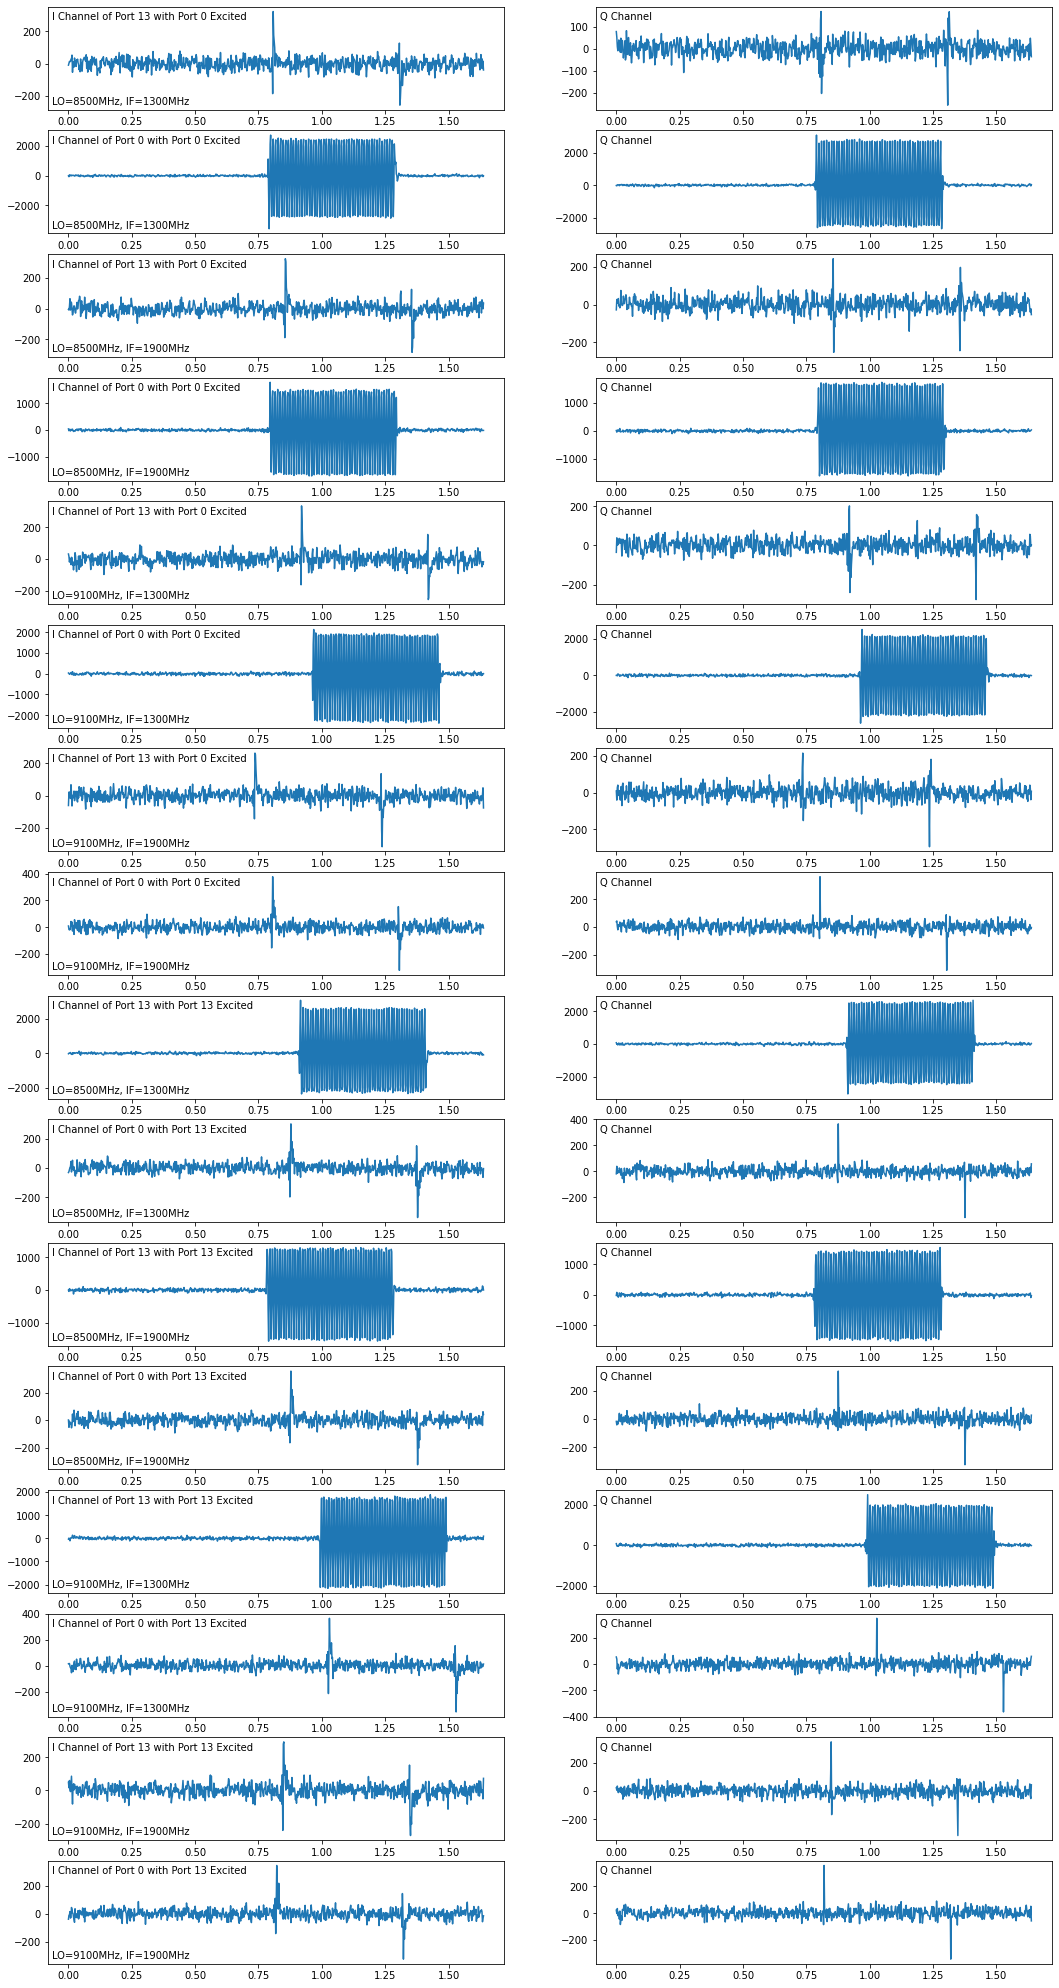

In [48]:
#グラフ描画

qube_id = '1_04'
fname = 'Qube{}_readin.pickle'.format(qube_id)
with open(fname, 'rb') as f:
    rslt = pickle.load(f)

SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
f, axs = plt.subplots(16,2, figsize=(18,36))
for i, d in enumerate(rslt):
    ax = axs[2*i:,:]
    myplot(ax, d.data)
    for k in [0, 1]:
        ax[k,0].text(0.01, 0.05, 'LO={}MHz, IF={}MHz'.format(d.fl, d.fi), transform=ax[k,0].transAxes)
        ax[k,0].text(0.01, 0.95, 'I Channel of Port {} with Port {} Excited'.format(['13', '0'][k], d.port), verticalalignment='top', transform=ax[k,0].transAxes)
        ax[k,1].text(0.01, 0.95, 'Q Channel', verticalalignment='top', transform=ax[k,1].transAxes)

[<CaptureUnit.U0: 0>, <CaptureUnit.U4: 4>]
Rx(fl=8500, fi=1300, port=13) {<CaptureUnit.U0: 0>: [(1.0, 3.0), (-12.0, -1.0), (-2.0, -8.0), (-3.0, -11.0), (9.0, -1.0), (-5.0, -4.0), (-4.0, -12.0), (-1.0, 0.0), (2.0, 2.0), (-10.0, -7.0), (-2.0, 3.0), (0.0, 4.0), (0.0, -5.0), (4.0, 6.0), (5.0, 8.0), (4.0, 3.0), (-8.0, 9.0), (-14.0, 2.0), (-4.0, -3.0), (9.0, -3.0), (4.0, 2.0), (-4.0, -4.0), (-5.0, 2.0), (-5.0, -1.0), (6.0, 6.0), (-11.0, 0.0), (-1.0, -9.0), (7.0, 3.0), (4.0, -7.0), (0.0, 6.0), (6.0, -4.0), (3.0, -4.0), (12.0, 3.0), (-1.0, -1.0), (-2.0, 3.0), (5.0, 8.0), (-13.0, 1.0), (6.0, -6.0), (2.0, 0.0), (-4.0, 6.0), (-3.0, 8.0), (-3.0, 0.0), (-11.0, -2.0), (3.0, -12.0), (-3.0, 7.0), (-10.0, 9.0), (-6.0, -8.0), (16.0, -3.0), (5.0, 7.0), (-8.0, 7.0), (2.0, -4.0), (5.0, -1.0), (11.0, 0.0), (0.0, 2.0), (15.0, -8.0), (15.0, -3.0), (-2.0, 9.0), (-6.0, -2.0), (8.0, -4.0), (-8.0, -1.0), (-6.0, 7.0), (-4.0, -4.0), (14.0, 6.0), (7.0, -7.0), (11.0, 1.0), (7.0, -2.0), (1.0, 4.0), (3.0, -4.0), (-19.0

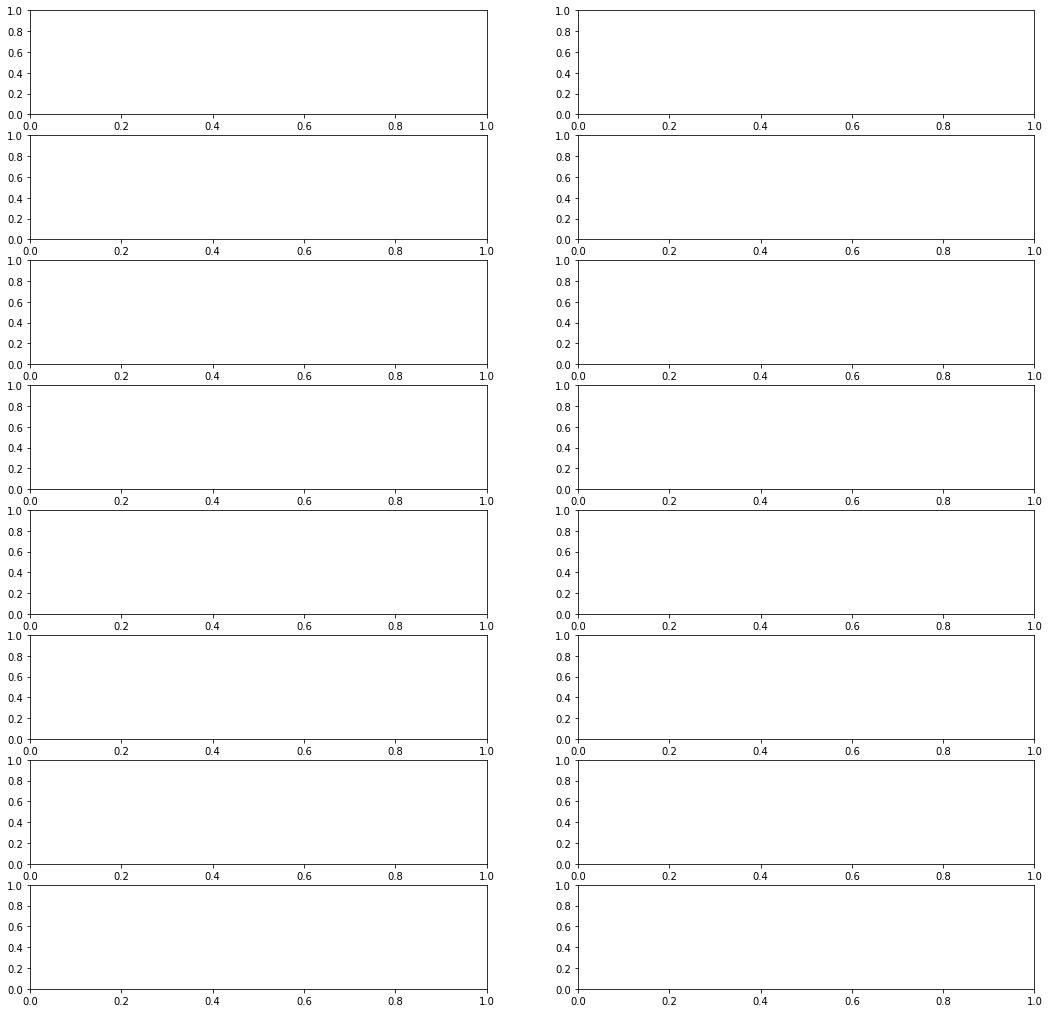

In [281]:
SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
f, axs = plt.subplots(8,2, figsize=(18,18))
for k, v in zip(rslt.items(), axs):
    fl, fi, port = k[0]
    print([i for i in k[1]][::4])
    print(k[0], k[1], v)

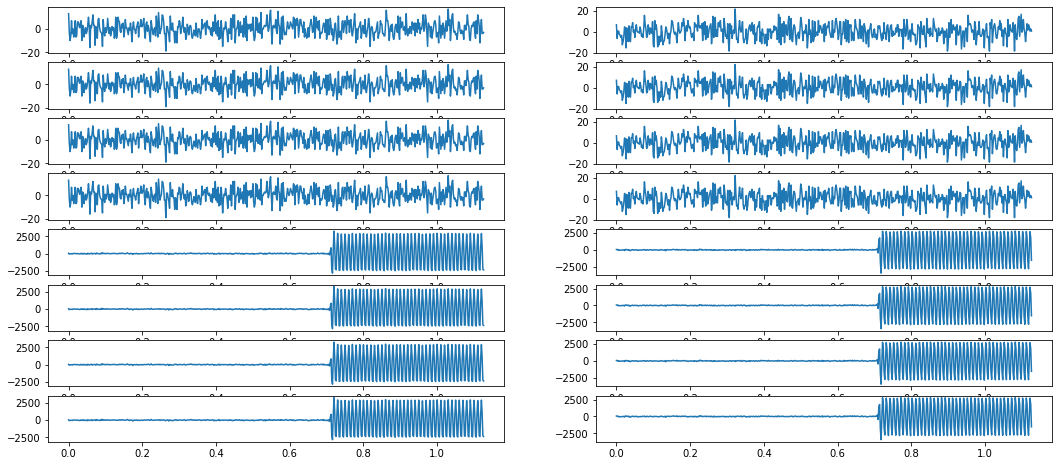

In [181]:
f, axs = plt.subplots(8,2, figsize=(18,8))
for i, v in enumerate(o):
    axs[i,0].plot(time, v[:,0])
    axs[i,1].plot(time, v[:,1])

## send_recv/send_recv.py

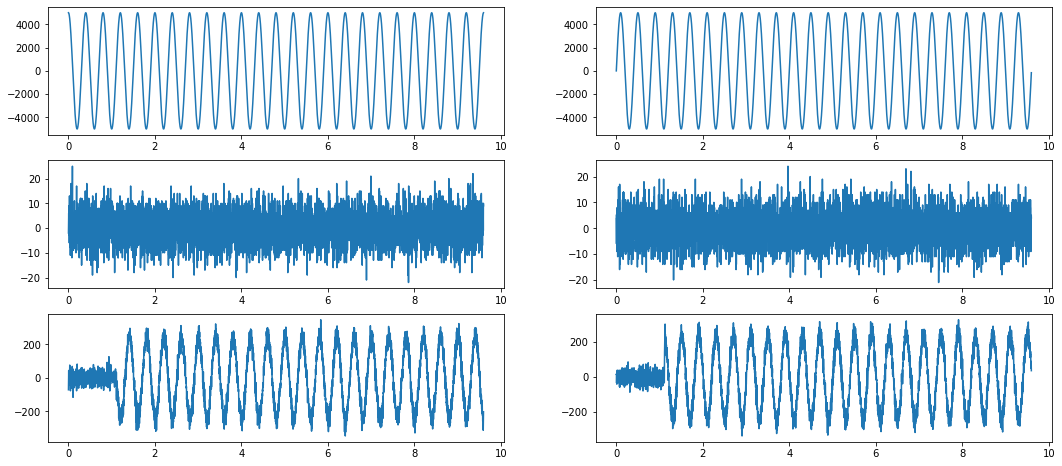

In [234]:
import e7awg_sw.examples.send_recv.send_recv as sr
from e7awg_sw.examples.send_recv.send_recv import AWG, CaptureModule

#sr.IP_ADDR = '10.1.0.23' #QUBE.config['ipfpga']
sr.IP_ADDR = QUBE.config['ipfpga']

def sendrecv(awgs, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*awgs)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, awgs[0], capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, awgs)
        # キャプチャパラメータの設定
        sr.set_capture_params(cap_ctrl, awg_to_wave_sequence[awgs[0]], capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*awgs)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *awgs)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, awgs, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        # 波形保存
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
    return awg_to_wave_data, capture_unit_to_capture_data
        # save_sample_data('awg', sr.AwgCtrl.SAMPLING_RATE, awg_to_wave_data)
        # save_sample_data('capture', sr.CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data)
    # print('end')

awgs = AWG.all()
o = sendrecv(awgs, CaptureModule.all(), False, 'localhost')

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

samples = o[1][0]
sampling_rate = sr.CaptureCtrl.SAMPLING_RATE
#sampling_rate = sr.AwgCtrl.SAMPLING_RATE
time = np.linspace(0, 1000000 * len(samples) / sampling_rate, len(samples), endpoint=False)

#print(len(samples), sampling_rate * 1e-6, time[0], time[-1])

tx_iq = np.array(o[0][0])
iq = np.array([v for k, v in o[1].items()])

f, axs = plt.subplots(3,2, figsize=(18,8))
axs[0,0].plot(time, tx_iq[:,0])
axs[0,1].plot(time, tx_iq[:,1])
axs[1,0].plot(time, iq[0,:,0])
axs[1,1].plot(time, iq[0,:,1])
axs[2,0].plot(time, iq[4,:,0])
axs[2,1].plot(time, iq[4,:,1])

## 参考資料

In [127]:
import qubelsi.qube
import inspect
import e7awgsw.awgctrl
print(inspect.getsource(qubelsi.adrf6780))
#print(inspect.getsource(qubelsi.lmx2594))
#print(inspect.getsource(qubelsi.ad9082))
#print(inspect.getsource(e7awgsw.awgctrl.AwgCtrl))

import qubelsi.udpsendrecv

class ADRF6780:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_mode(self):
        return self.handle.read_adrf6780(self.chip, 0x5)

    def set_usb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0000)

    def set_lsb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0400)

    def write_value(self, addr, value):
        return self.handle.write_adrf6780(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_adrf6780(self.chip, addr)

    def do_init(self, message_out=False, usb_mode=False):
        self.write_value(0x0, 0x4000)
        self.write_value(0x0, 0x0000)
        self.write_value(0x3, 0x0167)
        if usb_mode:
            self.write_value(0x5, 0x0000)
        else:            
            self.write_value(0x5, 0x0400)



In [31]:
print(inspect.getsource(qubelsi.lmx2594))

import qubelsi.udpsendrecv

class LMX2594:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_freq_100M(self):
        return self.handle.read_lmx2594(self.chip, 0x24)

    def write_freq_100M(self, value):
        val = self.handle.write_lmx2594(self.chip, 0x24, value)
        r0 = self.handle.read_lmx2594(self.chip, 0)
        self.handle.write_lmx2594(self.chip, 0, r0 | 0x08) # R0[3]=FCAL_EN
        return val

    def write_value(self, addr, value):
        return self.handle.write_lmx2594(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_lmx2594(self.chip, addr)

    def do_init(self, message_out=False, readout_mode=False, ad9082_mode=False):
        
        if ad9082_mode:
            self.write_value(0x00, 0x6612) # R6 [14]VCO_PHASE_SYNC=0
        else:
            self.write_value(0x00, 0x2612) # R6 [14]VCO_PHASE_SYNC=0, [9]OUT_MUTE=1
        

In [238]:
import qubecalib as qc
import pickle

PORT_ID = 0
VATT = 0xC00
TYPE = 'A'

qube = QUBE.qube

port = qc.new_port_handler(qube)

def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

set_sideband_config(qube.adrf6780, qube_type='A')


#fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
#result = []

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.losc, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.losc)

def set_nco(port, mhz):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)

# 9800, 10400, 11000
FL, FI = 8200, 1500
VATT = 0x800
PORT_ID=0
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
[set_nco_ifadc(port[PORT_ID], FI - 2.5, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)

FL = 11200
FI = 1500
VATT = 0xC00
PORT_ID=5
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)


2.4756043956043956